In [49]:
import numpy as np # fast math + arrays
import pandas as pd # read CSVs, data tables
import scipy.stats as st # probability models + .fit()
import matplotlib.pyplot as plt # plotting
from statsmodels.distributions.empirical_distribution import ECDF # ECDF: nonparametric cumulative curve

plt.rcParams.update({
"axes.spines.top": False, # cleaner axes
"axes.spines.right": False,
"axes.grid": True, # light grid helps read values
"grid.alpha": 0.25,
})

def plot_ecdf(data, ax=None, **kw):

    """
    Make an ECDF step plot.
    WHY: shows all data points; no bins; great for comparing to model CDFs.
    """

    ec = ECDF(data) # compute ECDF object (x,y steps)
    ax = ax or plt.gca() # use passed axes OR current axes
    ax.step(ec.x, ec.y, where="post", **kw)
    ax.set_xlabel("Closing price ($)")
    ax.set_ylabel("F_hat(x)") # F-hat = empirical CDF
    return ax

def aic(logL, k):

    """
    Compute Akaike Information Criterion.
    AIC = 2*k - 2*logL
    logL = maximized log-likelihood; k = # free parameters in model.
    Lower AIC -> better tradeoff fit vs complexity (same dataset only!).
    """

    return 2*k - 2*logL

def mean_from_params(dist_name, params):
    
    """
    Convert SciPy .fit() parameters -> model mean (in minutes).
    SciPy returns (shape[s], loc, scale) in this order for most continuous dists.
    NOTE: ’loc’ shifts the distribution; ’scale’ stretches it.
    """

    if dist_name == "gamma":
        a, loc, scale = params # a = shape (k)
        return loc + a*scale # Gamma mean = loc + k*theta
    elif dist_name == "weibull_min":
        c, loc, scale = params # c = shape
        # Weibull mean uses the gamma function:
        return loc + scale*st.gamma(1 + 1/c)
    elif dist_name == "lognorm":
        s, loc, scale = params # s = sigma (log-scale SD); scale = exp(mu)
        # mean = loc + scale * exp( sigma^2 / 2 )
        return loc + scale * np.exp(s**2 / 2)
    else:
        return np.nan # unknown model

In [ ]:
df = pd.read_csv('./data/vix.csv', parse_dates = ['Open time'])

df = df.drop(['Open', 'High', 'Low', 'Volume', 'Trade count', 'VWAP'], axis = 1)

split_date = pd.Timestamp('2024-07-15')

three_mo_before = pd.Timestamp('2024-04-15')
three_mo_after = pd.Timestamp('2024-10-15')

pre = df.loc[(df['Open time'] >= three_mo_before) & (df['Open time'] < split_date)].copy()
post = df.loc[(df['Open time'] <= three_mo_after) & (df['Open time'] >= split_date)].copy()

pre = pre.drop(['Open time'], axis = 1).astype(float)
post = post.drop(['Open time'], axis = 1).astype(float)

pre = pre.to_numpy()
post = post.to_numpy()

pre = pre.flatten()
post = post.flatten()

print(f"PRE n={pre.size}, mean=${pre.mean():.2f}")
print(f"POST n={post.size}, mean=${post.mean():.2f}")

PRE n=370, mean=$47.47
POST n=390, mean=$49.97


array([39.88  , 40.18  , 40.5604, 40.84  , 40.56  , 40.92  , 40.7196,
       40.62  , 40.76  , 40.7696, 40.96  , 41.16  , 42.1712, 42.7928,
       42.8   , 42.88  , 42.52  , 42.56  , 42.76  , 44.1324, 43.54  ,
       43.8   , 44.04  , 43.84  , 45.34  , 45.02  , 45.64  , 45.48  ,
       45.52  , 45.68  , 43.92  , 44.4784, 43.76  , 43.3   , 43.06  ,
       43.2   , 42.5196, 42.4   , 42.8   , 42.64  , 42.44  , 42.88  ,
       45.864 , 46.6   , 47.36  , 47.14  , 47.68  , 48.76  , 48.18  ,
       47.42  , 46.76  , 47.    , 48.6   , 49.16  , 47.12  , 46.44  ,
       46.44  , 47.12  , 46.8   , 46.4   , 46.2   , 45.72  , 45.4348,
       45.4756, 45.44  , 45.72  , 46.44  , 47.64  , 48.4   , 47.24  ,
       47.08  , 47.08  , 45.2468, 45.28  , 45.12  , 44.9192, 44.32  ,
       45.76  , 48.16  , 48.96  , 49.46  , 49.8812, 51.    , 49.96  ,
       61.3152, 59.    , 60.6   , 61.64  , 61.6004, 61.96  , 82.76  ,
       74.48  , 77.08  , 79.04  , 81.    , 87.4   , 70.38  , 66.56  ,
       64.    , 62.8

The data being analyzed is hourly VIX closing prices, PRE being from 04/15/2024 to 07/15/2024, and POST being from 07/15/2024 to 10/15/2024. 07/15/2024 is when a notable sector rotation occured, so the objective is to track VIX data before and after this shift to determine whether there is a significant change and whether sector rotation can be predicted through traditional distribution curves.

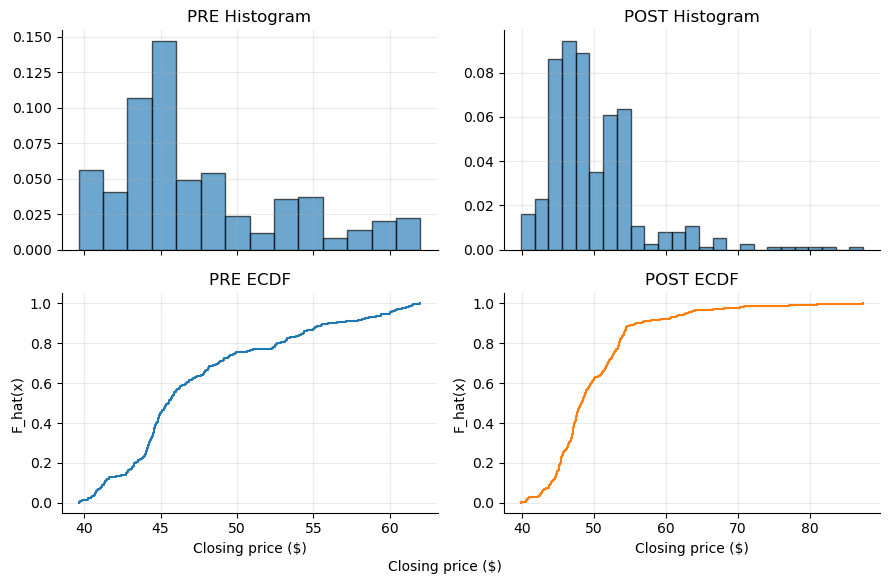

In [50]:
# --- 22 GRID: histograms (top) + ECDFs (bottom) --------------------------
fig, axs = plt.subplots(2, 2, figsize=(9,6), sharex='col')
# TOP ROW: HISTOGRAMS show approximate density
axs[0,0].hist(pre, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,0].set_title("PRE Histogram")
axs[0,1].hist(post, bins="auto", density=True, alpha=.65, edgecolor="k")
axs[0,1].set_title("POST Histogram")
# BOTTOM ROW: ECDFS show cumulative % of waits <= x
plot_ecdf(pre, ax=axs[1,0], color="C0"); axs[1,0].set_title("PRE ECDF")
plot_ecdf(post, ax=axs[1,1], color="C1"); axs[1,1].set_title("POST ECDF")
fig.text(0.5,0.04,"Closing price ($)", ha="center")
fig.tight_layout(rect=[0,0.04,1,1])
plt.show()

In [52]:
pre_75 = np.percentile(pre, 75)
pre_25 = np.percentile(pre, 25)
iqr_pre = pre_75 - pre_25

print("Outliers in PRE Period:")

for i in pre:
    if i > (pre_75 + 1.5 * iqr_pre) or i < (pre_25 - 1.5 * iqr_pre):
        print(i)

print('')

post_75 = np.percentile(pre, 75)
post_25 = np.percentile(post, 25)
iqr_post = post_75 - post_25

print("Outliers in POST Period:")

for i in post:
    if i > (post_75 + 1.5 * iqr_post) or i < (post_25 - 1.5 * iqr_post):
        print(i)

Outliers in PRE Period:
58.72
58.64
60.2
61.26
62.0
61.52
60.48
60.44
60.04
59.28
60.04
60.16
61.0472
61.402
59.12
59.44
59.4
59.44
60.04
60.32
60.0
60.6
61.0
61.12
60.8
61.88
61.48

Outliers in POST Period:
61.3152
59.0
60.6
61.64
61.6004
61.96
82.76
74.48
77.08
79.04
81.0
87.4
70.38
66.56
64.0
62.8
63.64
70.8
60.72
61.48
65.84
67.64
68.04
68.28
63.12
62.48
63.88
63.2
63.2
62.76
60.52
60.52
59.24
57.96
56.7
56.98
57.12
56.56
56.88


In [53]:
candidates = {
    "gamma": st.gamma,
    "weibull_min": st.weibull_min,
    "lognorm": st.lognorm,
    "invgauss": st.invgauss,
    "norm": st.norm,
    "t": st.t
}

print("Candidate models:", list(candidates))

Candidate models: ['gamma', 'weibull_min', 'lognorm', 'invgauss', 'norm', 't']


In [54]:
def fit_models(data, models):

    """
    Fit each SciPy distribution in ‘models‘ to 1-D numpy array ‘data‘.
    Returns a DataFrame (rows = models, columns = params/logL/k/AIC) sorted by AIC.
    """

    out = {}

    for name, dist in models.items():
        params = dist.fit(data) # MLE: find params that max log-likelihood
        logL = dist.logpdf(data, *params).sum() # total log-likelihood at those params
        k = len(params) # number of fitted parameters
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL,k))

    return pd.DataFrame(out).T.sort_values("AIC") # lower AIC = better
        
# --- FIT PRE & POST --------------------------------------------------------
fit_pre = fit_models(pre, candidates)
fit_post = fit_models(post, candidates)
print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)

PRE fits:


,params,logL,k,AIC
gamma,"(2.0444269298511344, 39.367260701292054, 3.963...",-1098.838716,3,2203.677432
weibull_min,"(1.4512966518888635, 39.57803882452501, 8.7116...",-1098.906187,3,2203.812373
invgauss,"(0.31345005258950664, 37.09246513978245, 33.10...",-1100.427085,3,2206.854169
lognorm,"(0.5555600056067345, 37.527530144321624, 8.552...",-1101.630649,3,2209.261298
norm,"(47.46994054054054, 5.5544690643811565)",-1159.410308,2,2322.820617
t,"(15.11815813601524, 47.1287398801351, 5.282170...",-1159.05056,3,2324.101119


POST fits:


,params,logL,k,AIC
lognorm,"(0.4421012180004797, 36.767362132225344, 11.94...",-1202.25744,3,2410.51488
invgauss,"(0.1958541664873046, 36.19977983301059, 70.330...",-1204.520263,3,2415.040527
gamma,"(3.2487063132706098, 39.150807427897064, 3.331...",-1209.304118,3,2424.608235
t,"(8.169991273850592, 49.860577237231546, 6.6153...",-1266.675401,3,2539.350802
norm,"(49.97421128205128, 6.573423455975207)",-1287.769589,2,2579.539177
weibull_min,"(0.9774123995259805, 39.879999999999995, 6.602...",-1334.510189,3,2675.020378


In [55]:
fit_pre['Delta AIC'] = fit_pre['AIC'] - fit_pre.loc['gamma', 'AIC']

fit_post['Delta AIC'] = fit_post['AIC'] - fit_post.loc['lognorm', 'AIC']

print("PRE fits:"); display(fit_pre)
print("POST fits:"); display(fit_post)

PRE fits:


,params,logL,k,AIC,Delta AIC
gamma,"(2.0444269298511344, 39.367260701292054, 3.963...",-1098.838716,3,2203.677432,0.0
weibull_min,"(1.4512966518888635, 39.57803882452501, 8.7116...",-1098.906187,3,2203.812373,0.134941
invgauss,"(0.31345005258950664, 37.09246513978245, 33.10...",-1100.427085,3,2206.854169,3.176737
lognorm,"(0.5555600056067345, 37.527530144321624, 8.552...",-1101.630649,3,2209.261298,5.583866
norm,"(47.46994054054054, 5.5544690643811565)",-1159.410308,2,2322.820617,119.143185
t,"(15.11815813601524, 47.1287398801351, 5.282170...",-1159.05056,3,2324.101119,120.423687


POST fits:


,params,logL,k,AIC,Delta AIC
lognorm,"(0.4421012180004797, 36.767362132225344, 11.94...",-1202.25744,3,2410.51488,0.0
invgauss,"(0.1958541664873046, 36.19977983301059, 70.330...",-1204.520263,3,2415.040527,4.525646
gamma,"(3.2487063132706098, 39.150807427897064, 3.331...",-1209.304118,3,2424.608235,14.093355
t,"(8.169991273850592, 49.860577237231546, 6.6153...",-1266.675401,3,2539.350802,128.835922
norm,"(49.97421128205128, 6.573423455975207)",-1287.769589,2,2579.539177,169.024297
weibull_min,"(0.9774123995259805, 39.879999999999995, 6.602...",-1334.510189,3,2675.020378,264.505498


Accurate for PRE: gamma, weibull_min

Accurate for POST: lognorm

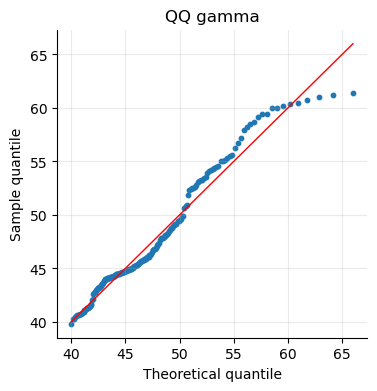

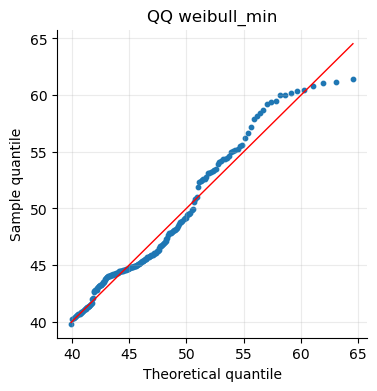

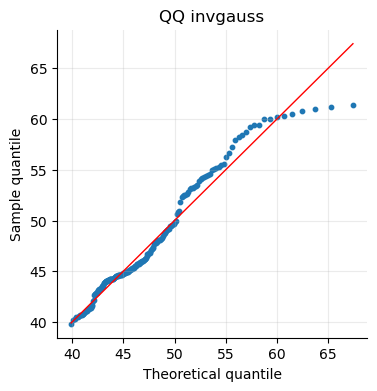

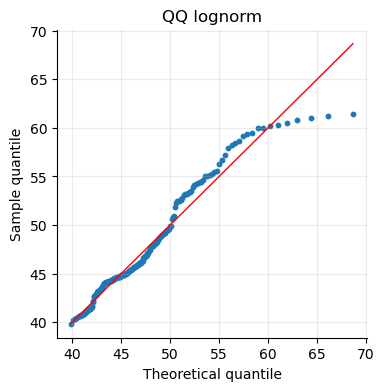

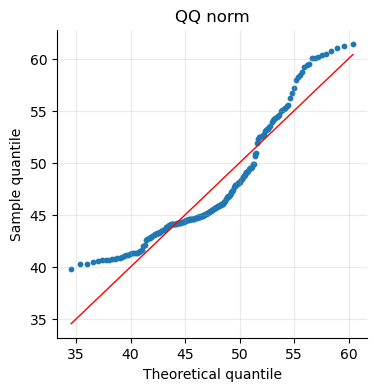

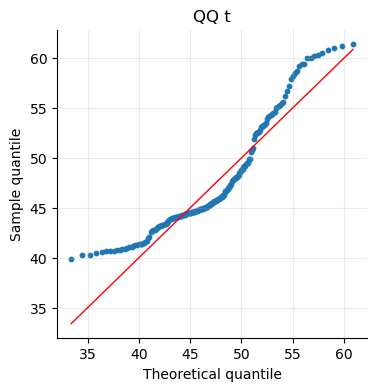

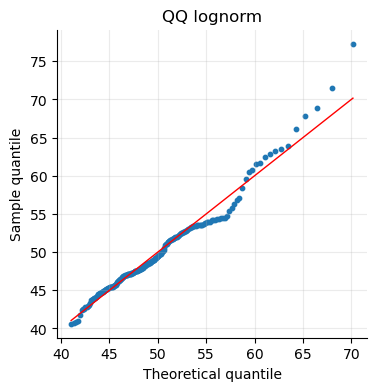

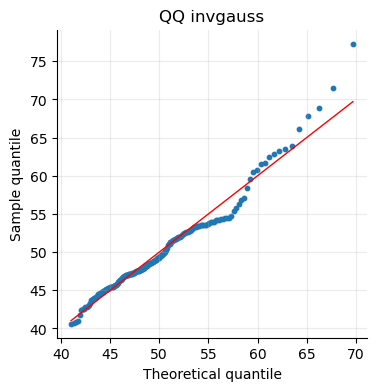

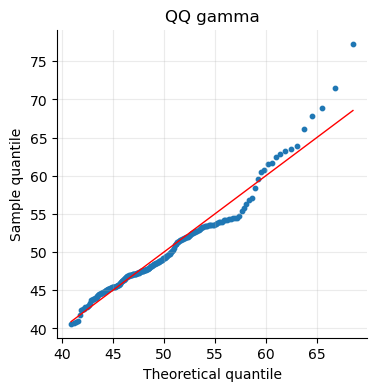

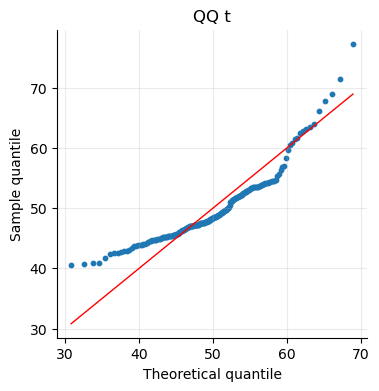

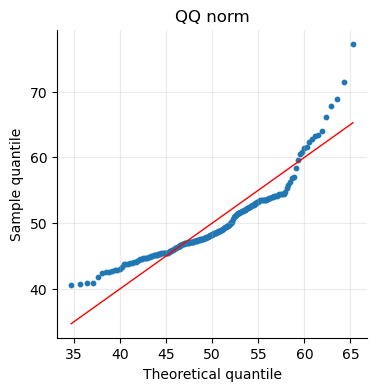

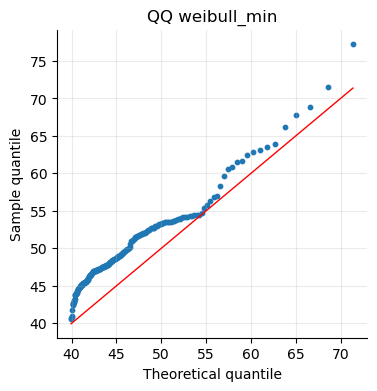

In [56]:
def qq_compare(data, fit_tbl, models, probs=np.linspace(.01,.99,200)):

    """
    Make QQ plots for each fitted model in fit_tbl.
    'probs' are the quantile levels (0-1) we compare.
    """

    qs = np.quantile(data, probs) # sample quantiles from data
    for name in fit_tbl.index: # models in AIC order
        dist = models[name]
        params = fit_tbl.loc[name,"params"]
        qt = dist.ppf(probs, *params) # theoretical quantiles from model
        plt.figure(figsize=(4,4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1) # 45 reference line
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()

# --- MAKE QQ PLOTS ---------------------------------------------------------
qq_compare(pre, fit_pre, candidates)
qq_compare(post, fit_post, candidates)

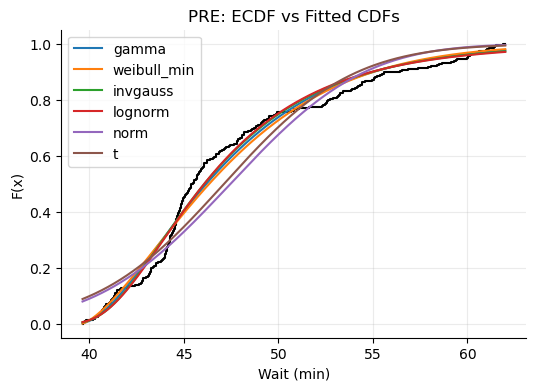

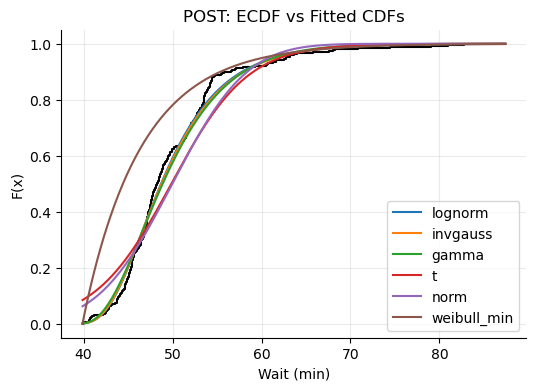

In [57]:
def cdf_overlay(data, fit_tbl, models, title):

    """
    ECDF (black steps) + each fitted model’s CDF (smooth lines).
    """

    plt.figure(figsize=(6,4))
    plot_ecdf(data, color="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
        plt.legend(); plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("F(x)")
        
# --- MAKE CDF OVERLAYS -----------------------------------------------------
cdf_overlay(pre, fit_pre, candidates, title="PRE: ECDF vs Fitted CDFs")
cdf_overlay(post, fit_post, candidates, title="POST: ECDF vs Fitted CDFs")

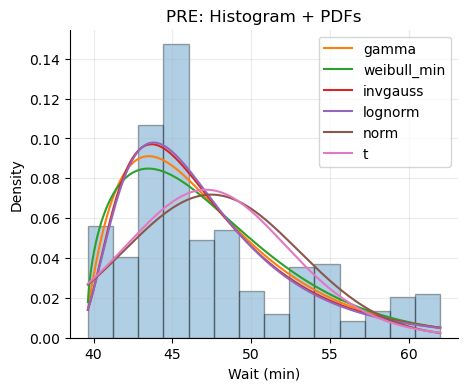

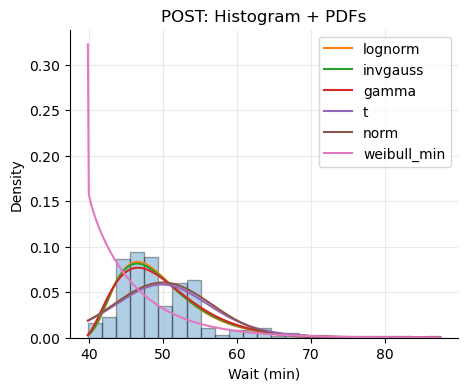

In [58]:
def pdf_overlay(data, fit_tbl, models, title):

    """
    Histogram (density=True) + PDFs from each fitted model.
    """
    
    plt.figure(figsize=(5,4))
    plt.hist(data, bins="auto", density=True, alpha=.35, edgecolor="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
        plt.legend(); plt.title(title)
        plt.xlabel("Wait (min)"); plt.ylabel("Density")

# --- MAKE PDF OVERLAYS -----------------------------------------------------
pdf_overlay(pre, fit_pre, candidates, "PRE: Histogram + PDFs")
pdf_overlay(post, fit_post, candidates, "POST: Histogram + PDFs")


In [60]:
# --- PICK BEST MODELS BY AIC -----------------------
best_pre = fit_pre.index[0]
best_post = fit_post.index[0]
# --- GET MEANS FROM FITTED PARAMS ------------------------------------------
mu_pre = mean_from_params(best_pre, fit_pre.loc[best_pre,"params"])
mu_post = mean_from_params(best_post, fit_post.loc[best_post,"params"])
# --- PRACTICAL CHANGE -------------------------------------------------------
delta = mu_post - mu_pre
ratio = mu_post / mu_pre
print(f"Best PRE model: {best_pre} mean: ${mu_pre:.2f}")
print(f"Best POST model: {best_post} mean: ${mu_post:.2f}")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f})")

Best PRE model: gamma mean: $47.47
Best POST model: lognorm mean: $49.93
Change POST-PRE: +2.46 min (1.05)


Overall, POST showed a slight increase of $2.46, but it is unclear whether this difference is actually significant and can be used to predict sector rotation. More importantly, these visualizations show that it is difficult to model VIX using curves such as the normal distribution, gamma distribution, etc., as even the distributions with the lowest AIC displayed relatively inaccurate results when looking at the QQ graph and the histogram overlay.